In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
import numpy as np

In [3]:
from app.algorithms import compute_urm, compute_utm, compute_em, compute_stm
from app.data import generate_synthetic_data

In [4]:
import tqdm
import random
import matplotlib.pyplot as plt

### Synthetic data

In [5]:
# arguments for generating the data

M = 70 # data dimension
UNIFORM = True # True = model has uniform residual variances; False = models has arbitrary residual variances
OBJECTIVE = False # False = independent objective; True = aligned objective
scan_N = (np.array([0.25, 0.5, 1, 2]) * M).astype(np.int) # the sizes of datasets
default_K = np.array([5, 9, 15, 20]) # the corresponding K to use
default_lambda = np.array([2.6, 1.4, 1, .9]) * M # the corresponding lambda to use
default_gamma = np.array([8, 6, 4, 2]) * M
TRIAL = 100 # number of simulation trials
mu_f = -1
sigma_f = 2 # magnitude factor loadings
sigma_p = 4
sigma_r = 0.6 # magnitude of variation among residual variances

## UTM / URM

In [6]:
## log likelihood record keeper
UTM_llh = np.zeros((TRIAL, len(scan_N)))
URM_llh = np.zeros((TRIAL, len(scan_N)))
wrong_llh = np.zeros((TRIAL, len(scan_N)))

UTM_obj = np.zeros((TRIAL, len(scan_N)))
URM_obj = np.zeros((TRIAL, len(scan_N)))
Oracle_obj = np.zeros((TRIAL, len(scan_N)))

## set random seed for data generation; can be safely ignored
rand_seed = random.randint(0, 10000);
print("Seed: %d" % rand_seed)
np.random.seed(rand_seed)

# begin of simulation
for trial in tqdm.tqdm(range(TRIAL)):
    X, Sigma_s, c = generate_synthetic_data(M, scan_N[-1], UNIFORM, OBJECTIVE, mu_f, sigma_f, sigma_p, sigma_r) # X=data set; Sigma_s = true covariance matrix
            
    for index_N, (N, train_K, train_lambda, train_gamma) in enumerate(zip(scan_N, default_K, default_lambda, default_gamma)):
        # compute sample covaraince matrix
        Sigma_SAM = np.zeros((M,M))
        for n in range(N):
            Sigma_SAM += np.outer(X[:,n], X[:,n])
        Sigma_SAM /= N
                     
        if UNIFORM:
            # URM
            Sigma_URM = compute_urm(Sigma_SAM, train_K)
            # TODO: turn into function
            U_URM = 0.5 * np.linalg.lstsq(Sigma_URM, c, rcond=None)[0]
            URM_llh[trial, index_N] = -0.5 * (M * np.log(2*np.pi) + np.log(np.linalg.det(Sigma_URM)) + np.trace(np.linalg.lstsq(Sigma_URM, Sigma_s, rcond=None)[0]))
            URM_obj[trial, index_N] = c.dot(U_URM) - U_URM.dot(Sigma_s).dot(U_URM)
            
            # UTM
            Sigma_UTM = compute_utm(Sigma_SAM, train_lambda, N)
            U_UTM = 0.5 * np.linalg.lstsq(Sigma_UTM, c, rcond=None)[0]
            UTM_llh[trial, index_N] = -0.5 * (M * np.log(2*np.pi) + np.log(np.linalg.det(Sigma_UTM)) + np.trace(np.linalg.lstsq(Sigma_UTM, Sigma_s, rcond=None)[0]))
            UTM_obj[trial, index_N] = c.dot(U_UTM) - U_UTM.dot(Sigma_s).dot(U_UTM)
            
            #U_oracle = 0.5 * np.linalg.lstsq(Sigma_s, c, rcond=None)[0]
            #Oracle_obj[trial, index_N] = c.dot(U_oracle) - U_oracle.dot(Sigma_s).dot(U_oracle)

  2%|▏         | 2/100 [00:00<00:07, 12.95it/s]

Seed: 6603


100%|██████████| 100/100 [00:08<00:00, 11.98it/s]


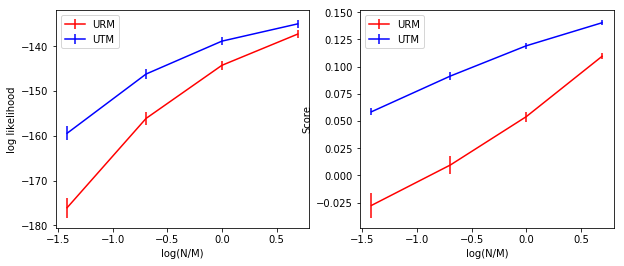

In [7]:
# plot the results
log_scan_N = np.log(scan_N/M)
plt.figure(figsize = (10,4))
plt.subplot(121)
if UNIFORM:
    plt.errorbar(log_scan_N, URM_llh.mean(axis=0), URM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='r', ms=4, label='URM')
    plt.errorbar(log_scan_N, UTM_llh.mean(axis=0), UTM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='b', ms=4, label='UTM')
    
plt.xlabel('log(N/M)');
plt.ylabel('log likelihood');
plt.legend()


plt.subplot(122)
if UNIFORM:
    plt.errorbar(log_scan_N, URM_obj.mean(axis=0), URM_obj.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='r', ms=4, label='URM')
    plt.errorbar(log_scan_N, UTM_obj.mean(axis=0), UTM_obj.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='b', ms=4, label='UTM')
    #plt.errorbar(log_scan_N, Oracle_obj.mean(axis=0), Oracle_obj.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='k', ms=4, label='Oracle')
    
plt.xlabel('log(N/M)');
plt.ylabel('Score');
plt.legend()
plt.show()

## STM / EM

In [8]:
UNIFORM = False
## log likelihood record keeper
STM_llh = np.zeros((TRIAL, len(scan_N)))
EM_llh = np.zeros((TRIAL, len(scan_N)))
wrong_llh = np.zeros((TRIAL, len(scan_N)))

STM_obj = np.zeros((TRIAL, len(scan_N)))
EM_obj = np.zeros((TRIAL, len(scan_N)))
Oracle_obj = np.zeros((TRIAL, len(scan_N)))


## set random seed for data generation; can be safely ignored
rand_seed = random.randint(0, 10000);
print("Seed: %d" % rand_seed)
np.random.seed(rand_seed)

# begin of simulation
for trial in tqdm.tqdm(range(TRIAL)):
    X, Sigma_s, c = generate_synthetic_data(M, scan_N[-1], UNIFORM, OBJECTIVE, mu_f, sigma_f, sigma_p, sigma_r) # X=data set; Sigma_s = true covariance matrix
            
    for index_N, (N, train_K, train_lambda, train_gamma) in enumerate(zip(scan_N, default_K, default_lambda, default_gamma)):
        # compute sample covaraince matrix
        Sigma_SAM = np.zeros((M,M))
        for n in range(N):
            Sigma_SAM += np.outer(X[:,n], X[:,n])
        Sigma_SAM /= N
                     
        if not UNIFORM:
            # STM
            Sigma_STM = compute_stm(Sigma_SAM, train_lambda, N)
            U_STM = 0.5 * np.linalg.lstsq(Sigma_STM, c, rcond=None)[0]
            STM_llh[trial, index_N] = -0.5 * (M * np.log(2*np.pi) + np.log(np.linalg.det(Sigma_STM)) + np.trace(np.linalg.lstsq(Sigma_STM, Sigma_s, rcond=None)[0]))
            STM_obj[trial, index_N] = c.dot(U_STM) - U_STM.dot(Sigma_s).dot(U_STM)
            
            # EM
            Sigma_EM = compute_em(Sigma_SAM, train_K)
            U_EM = 0.5 * np.linalg.lstsq(Sigma_EM, c, rcond=None)[0]
            EM_llh[trial, index_N] = -0.5 * (M * np.log(2*np.pi) + np.log(np.linalg.det(Sigma_EM)) + np.trace(np.linalg.lstsq(Sigma_EM, Sigma_s, rcond=None)[0]))
            EM_obj[trial, index_N] = c.dot(U_EM) - U_EM.dot(Sigma_s).dot(U_EM)
            
            #U_oracle = 0.5 * np.linalg.lstsq(Sigma_s, c, rcond=None)[0]
            #Oracle_obj[trial, index_N] = c.dot(U_oracle) - U_oracle.dot(Sigma_s).dot(U_oracle)

  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 9450


/home/deebee/personal-work/courses/spring21/ml-finance/presentation/app/algorithms.py:92: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  dt, _, _, _ = np.linalg.lstsq(-hessian, gradient)
100%|██████████| 100/100 [35:56<00:00, 19.24s/it] 


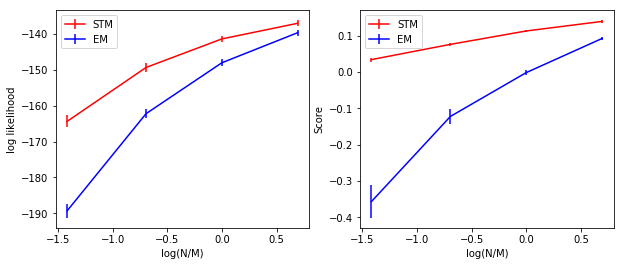

In [9]:
# plot the results
log_scan_N = np.log(scan_N/M)
plt.figure(figsize = (10,4))
plt.subplot(121)
if not UNIFORM:
    plt.errorbar(log_scan_N, STM_llh.mean(axis=0), STM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='r', ms=4, label='STM')
    plt.errorbar(log_scan_N, EM_llh.mean(axis=0), EM_llh.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='b', ms=4, label='EM')
    
plt.xlabel('log(N/M)');
plt.ylabel('log likelihood');
plt.legend()


plt.subplot(122)
if not UNIFORM:
    plt.errorbar(log_scan_N, STM_obj.mean(axis=0), STM_obj.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='r', ms=4, label='STM')
    plt.errorbar(log_scan_N, EM_obj.mean(axis=0), EM_obj.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='b', ms=4, label='EM')
    #plt.errorbar(log_scan_N, Oracle_obj.mean(axis=0), Oracle_obj.std(axis=0, ddof=1)/np.sqrt(TRIAL), c='k', ms=4, label='Oracle')
    
plt.xlabel('log(N/M)');
plt.ylabel('Score');
plt.legend()
plt.show()